## Data Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import shap
from mlxtend.plotting import plot_decision_regions

In [11]:
df = pd.read_excel('data.xlsx', skiprows=range(1900, 2200))

In [12]:
df

,product_range,service,shopping_days,income,other_markets,internet,credit_card,age,gender,loan,distance,retention
0,54,64,2,2.1,3,0,0,54,0,1,1.6,1
1,86,88,6,2.3,2,0,1,72,1,1,6.5,1
2,56,60,2,2.1,3,0,0,56,1,0,0.4,1
3,54,61,2,2.1,3,0,1,60,1,1,6.5,1
4,63,60,2,2.1,3,0,0,41,1,1,7.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7464,8,8,3,1.6,4,1,1,51,0,1,23.2,0
7465,10,10,3,2.6,4,1,1,31,0,1,12.3,0
7466,46,46,2,1.8,4,1,1,60,0,0,12.1,0
7467,16,16,3,2.4,4,1,1,55,0,1,11.4,0


## Exploratory data analysis

### Data description

- **product_range**: satisfaction with product range at market X (from survey) 0 - 100 points.
- **service**: satisfaction with service at market X (from survey) 0 -100 points.
- **shopping_days**: number of days per week when the customer shops
- **income**: average income
- **other_markets**: number of other markets client shops at
- **internet**: does client shop online (0 - no, 1 - yes)
- **credit_card**: does client have a credit card (0 - no, 1 - yes)
- **age**: age in years
- **gender**: 0 - male, 1 - female
- **loan**: does client have a credit/loan/mortgage (0 - no, 1 - yes)
- **distance**: distance of residence (km)
- **retention**: whether client intends to shop at market X in the future (0 - no, 1 - yes) - **dependent variable**.

### Missing data & descriptive statistics

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469 entries, 0 to 7468
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_range  7469 non-null   int64  
 1   service        7469 non-null   int64  
 2   shopping_days  7469 non-null   int64  
 3   income         7469 non-null   float64
 4   other_markets  7469 non-null   int64  
 5   internet       7469 non-null   int64  
 6   credit_card    7469 non-null   int64  
 7   age            7469 non-null   int64  
 8   gender         7469 non-null   int64  
 9   loan           7469 non-null   int64  
 10  distance       7469 non-null   float64
 11  retention      7469 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 700.3 KB


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
product_range,7469.0,41.768912,26.407673,0.0,19.0,40.0,59.0,90.0
service,7469.0,53.019949,31.423494,0.0,26.0,56.0,81.0,100.0
shopping_days,7469.0,3.982461,1.504711,2.0,3.0,4.0,5.0,7.0
income,7469.0,2.389410,0.658691,1.0,2.0,2.3,2.8,3.9
other_markets,7469.0,3.239657,1.529876,1.0,2.0,4.0,5.0,6.0
internet,7469.0,0.488553,0.499902,0.0,0.0,0.0,1.0,1.0
credit_card,7469.0,0.365779,0.481680,0.0,0.0,0.0,1.0,1.0
age,7469.0,47.808676,12.869080,18.0,38.0,48.0,57.0,74.0
gender,7469.0,0.447851,0.497306,0.0,0.0,0.0,1.0,1.0
loan,7469.0,0.875887,0.329732,0.0,1.0,1.0,1.0,1.0


- *info()* method showed that missing data are not present in the table. 
- It is also evident from the basic descriptive statistics that there are no observations where the values are ‘unnatural’ for the variable, so there is no need to remove observations
- In addition, by comparing the arithmetic mean and median of some of the numeric variables (i.e. product_range, service, age, distance), it can be seen that their distribution may be close to symmetric, so a transformation of the variables (not counting scaling) is unlikely to be necessary.

## Classification

### Data class balance

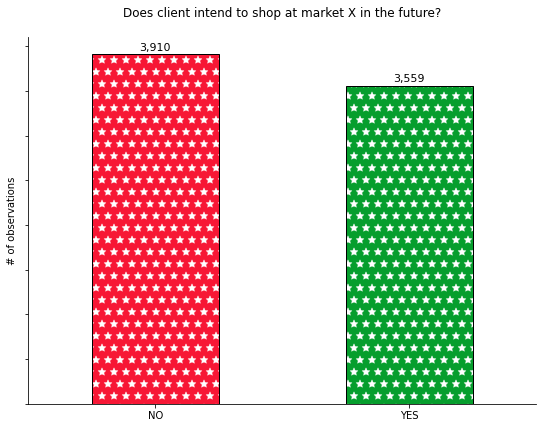

In [15]:
with plt.rc_context({'hatch.linewidth': 0.4}):
    plt.figure(figsize=(8, 6))
    ax = df['retention'].value_counts().plot(kind='bar',
                                          color=['#F71735', '#069E2D'],
                                          hatch='*',
                                          edgecolor='black')
    plt.ylabel('# of observations')
    plt.title('Does client intend to shop at market X in the future?', pad=20)
    plt.tight_layout()
    ax.set_xticklabels(('NO', 'YES'))
    container = ax.containers[0]
    ax.bar_label(container,
                 labels=[f'{v:,}' for v in container.datavalues],
                 fontsize=11,
                 padding=2)
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for patch in ax.patches:
        patch._hatch_color = (1.0, 1.0, 1.0, 1.0)
    plt.xticks(rotation=0)
    plt.show()

It can be inferred from the column chart that the values of the dichotomous dependent variable are fairly balanced, so there is no need to delete or generate new observations.

### Selection of independent variables

**Internet & Age**.

- Benefits of buying online:
    - time saving (no need to visit shops in person to find a product and compare prices) 
    - the possibility of becoming better acquainted with commercial offers
    - convenience, comfort (e.g. ability to access a shop 24/7, no need to be physically present in the shop)
    - no need to personally transport the product home
    - the opportunity to learn about the opinions of other product users
- Limitations of online shopping:
    - no possibility to ‘get to know the product up close’ (i.e. touch, try it on or try it out) 
    - not being able to receive the product immediately at the time of purchase
    - concerns about security of purchases (e.g. payments)
    - worries about delivery problems
    - being used to traditional sales channels

    
*Stolecka-Makowska, A. (2016). Zakupy konsumentów przez Internet w Polsce i Unii Europejskiej-analiza porównawcza. Studia Ekonomiczne, (302), 162-174.*
        
Willingness to buy online may be associated with a lower likelihood of revisiting a market, so the variable **internet** will be taken into account. In addition, a variable related to **age** may be associated with willingness to buy via **internet** - older people often do not use the internet at all, or are distrustful when it comes to online payments.

**Gender & Shopping Days**

The vast majority of respondents, up to 90% of women and 92% of men, shop several times a week. Less than 10% of women and 2% of men shop weekly and 4% of men choose to shop several times a month. Only 2% of female respondents said they shop once a month and 2% of male respondents said they shop less than once a month.

The largest group of women, 43%, declare that they most often spend money on clothes (29% of men spend money for this purpose). On the other hand, 44% of men admit that they most often spend money on groceries. 17% of female respondents spend money most often on cosmetics, while 6% of them spend money on all kinds of accessories. The same number of women and men (10%) spend money most often on books. Nine per cent of men spend their income on music CDs, and 6% spend their income on audiovisual equipment.

Statistically significant differences were found in the products most frequently purchased by women and men. These differences relate to both cosmetics (0.001), clothing (0.046) and food products (0.003).

*Makarewicz, M., Piechota, M., Story, W., & Wadowska, W. (2012). Płeć a zakupoholizm.„. Innowacje psychologiczne, 1(1), 29-46.*

The research shows that while shopping frequency is similar in terms of gender, differences are significant in terms of products purchased. Due to the fact that the market is analysed, **gender** may have an impact on the dependent variable.

The effect of **shopping_days** on the dependent variable will be analysed in the graphs.

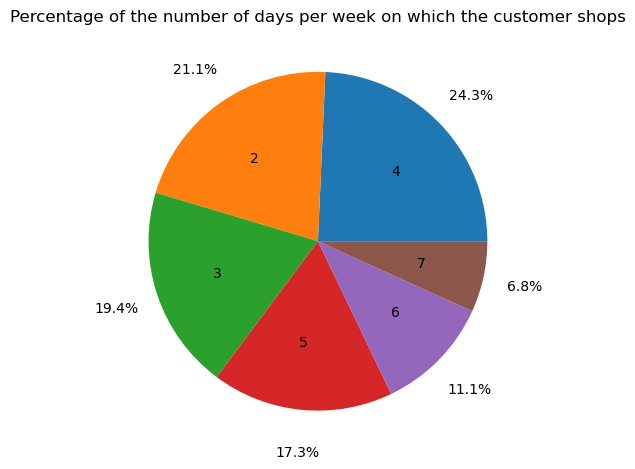

In [16]:
shopping_freq = df['shopping_days'].value_counts()

with plt.style.context('seaborn-v0_8-notebook'):
    plt.pie(shopping_freq.values,
            labels=shopping_freq.index,
            autopct='%1.1f%%',
            pctdistance=1.25,
            labeldistance=.6)
    plt.title(
        'Percentage of the number of days per week on which the customer shops')
    plt.show()

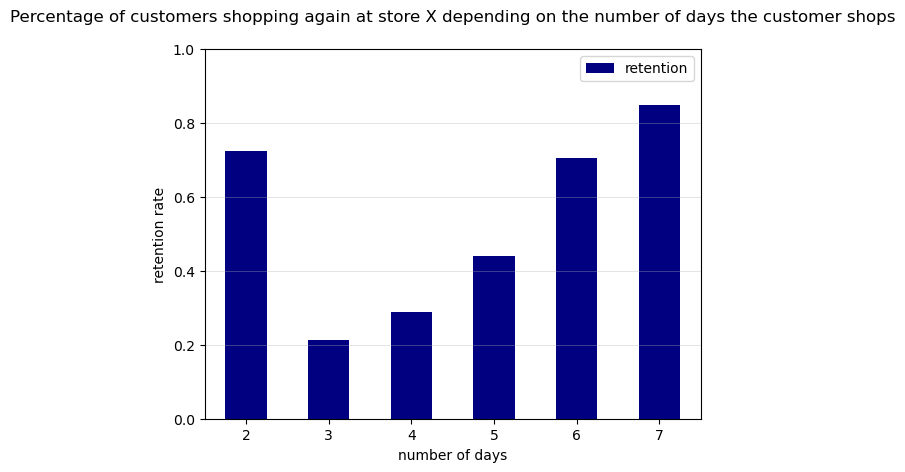

In [27]:
df.groupby('shopping_days').mean().plot(y='retention', kind='bar', color='#000080')
plt.ylabel('retention rate')
plt.xlabel('number of days')
plt.ylim(0, 1)
plt.grid(axis='y', linewidth=0.6, alpha=0.4)
plt.title(
    'Percentage of customers shopping again at store X depending on the number of days the customer shops',
    pad=20)
plt.xticks(rotation=0)
plt.show()

As can be seen from the graph above, the number of shopping days may have an impact on the retention of the client. With regard to two-day shoppers, it cannot be said that there is a stable trend in the number of days a person shops and the proportion of repeat purchases at store X. However, it can be concluded that the number of days is correlated with **dependent variable**.

**Income & Loan**

The amount of income determines the extent of consumption freedom by forcing or encouraging the choice of different needs. Income is an important factor because: it is shaped in the sphere of distribution, i.e. it is a primary factor to the others, it is the main, quantitative factor that determines demand and consumption, it makes it possible to analyse them according to a number of additional characteristics
differentiating consumers. High income also increases the level of access to online banking.

Another way to increase income is through loans, which allow for earlier consumption of goods than current income allows. They allow the purchase of many goods in the short term, thereby increasing society's purchasing capacity, but will constrain it in the future due to the need for repayment. Credit and savings have an important function in meeting higher-order needs, whereas purchases of basic products are usually financed from current income. **They therefore have no impact on the consumption of food and basic goods, except in connection with a sudden and significant drop in income.**

*Cyran, K. (2014). Dochód jako czynnik różnicujący zachowania konsumentów na rynku żywności (na przykładzie mieszkańców województwa podkarpackiego). Nierówności społeczne a wzrost gospodarczy, 38, 365-374.*

It was therefore decided to take the variable **income** into account, while discarding the variable **loan**.

**Credit card**

Of all Poles, 13% have and use a credit card, while 4% have one but do not use it (2014). 
The above actions of the banks were influenced by the increasing value of non-performing loans, including consumer credit card loans, between 2009 and 2011. At the end of December 2012, the ratio of non-performing loans to total credit card loans was 16.8%. 

The results of the research into the payment behaviour of Poles also show where we are most likely to pay by card. **We use the card most often, as much as 47% of the time, at petrol stations, and least often - only 5% - during everyday grocery shopping at small shops, markets and bazaars.

In general, more cash transactions are made by people living in rural areas, elderly, unmarried, less educated and treating new technologies with caution.

*Kapler, M. (2014). Analiza decyzji zakupowych polskich konsumentów, uwarunkowanych wyborem formy płatności. Zeszyty Naukowe. Organizacja i Zarządzanie/Politechnika Śląska.*

Although the research shows that having a credit card can influence the type of establishment we are willing to shop at, it is also important to consider that the research was done around 10 years ago and since then alternative (to cash) payment methods are more ubiquitous, so it is worth investigating **the impact of having a credit card on the dependent variable.**

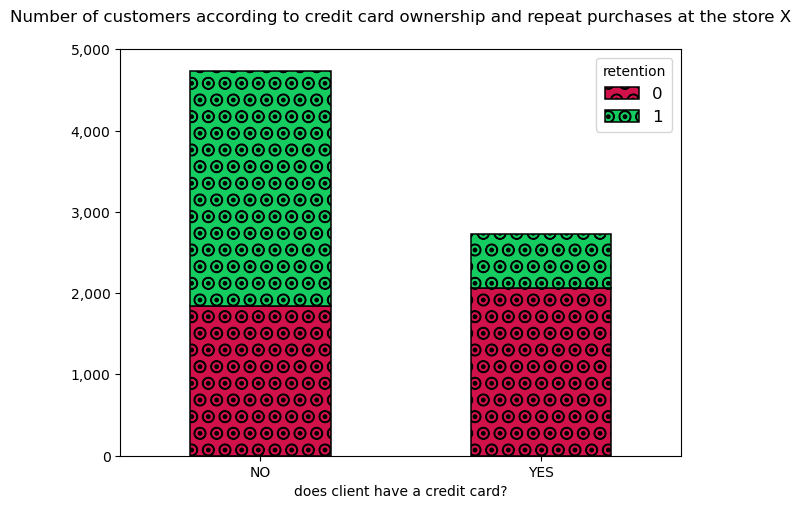

In [19]:
credit_cust = df.groupby('credit_card',
                         as_index=False).value_counts(subset=['retention']).pivot(
                             index='credit_card',
                             columns='retention',
                             values='count')

ax = credit_cust.plot(kind='bar',
                      stacked=True,
                      color=['#D11149', '#14CC60'],
                      edgecolor='black',
                      linewidth=1.1,
                      hatch='O.')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.ylim(0, 5_000)
plt.xlabel('does client have a credit card?')
plt.tight_layout()
plt.title(
    'Number of customers according to credit card ownership and repeat purchases at the store X',
    pad=20)
ax.set_xticklabels(('NO', 'YES'))
plt.xticks(rotation=0)
plt.legend(title='retention', fontsize='larger')
plt.show()

Non-credit card holders, *forming a clear majority of observations*, are considerably more likely to return to market X. The variable may therefore have an effect on the **dependent variable**.

**Product range, service, number of other markets and distance of residence**.

- As product range and service are variables that measure customer satisfaction, they seem to be logically related to the dependent variable, thus they will be concluded in the following analysis
- The number of other marketplaces where the customer shops can also affect the dependent variable. The customer may decide that another, competing market is simply better and stop visiting our market (market X)
- For people living further away, visiting the market may not be particularly convenient, so this variable may also affect the dependent variable.

In [20]:
X_clf = df.drop(['retention', 'loan'], axis=1)
y_clf = df['retention'].copy()

**Splitting data into test set and train set**

In [21]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42)

The set was divided into training and testing at a ratio of **80/20**.

In [22]:
search_params = {
    'cv': 5,
    'scoring': 'accuracy',
    'n_iter': 20,
    'random_state': 42
}

In [23]:
def feature_importance_plot(feature_importances, X, permutated=False):

    features = pd.DataFrame(feature_importances,
                            index=X.columns,
                            columns=['Importances'])
    features.sort_values(by=['Importances'], inplace=True)
    color = 'orange' if permutated else 'steelblue'
    plt.barh(features.index, features['Importances'], color=color)
    plt.title('Feature importances')
    plt.show()

It was decided to make feature importance graphs for each of the selected models, so in order to reduce code redundancy, a function was written to generate a feature importance graph sorted from most important to least important.

In [28]:
lg_clf = LogisticRegression(max_iter = 1000)

lg_clf.fit(X_train_clf, y_train_clf)

LogisticRegression(max_iter=1000)

In [29]:
lg_clf.score(X_test_clf, y_test_clf)

0.8440428380187416

In [30]:
lg_clf.coef_

array([[-0.00509508,  0.01572968, -0.0709214 ,  0.29624783, -0.64989288,
         0.00644016, -0.68028583,  0.00797269,  0.28304158, -0.0108117 ]])

In [31]:
lg_clf.coef_[0]

array([-0.00509508,  0.01572968, -0.0709214 ,  0.29624783, -0.64989288,
        0.00644016, -0.68028583,  0.00797269,  0.28304158, -0.0108117 ])

In [32]:
for k, v in zip(X_clf.columns, lg_clf.coef_[0]):
    
    print(f"{k:12} {v:.3f}")

product_range -0.005
service      0.016
shopping_days -0.071
income       0.296
other_markets -0.650
internet     0.006
credit_card  -0.680
age          0.008
gender       0.283
distance     -0.011


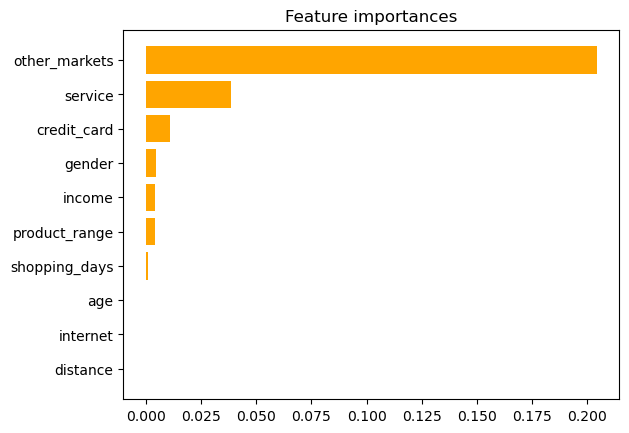

In [33]:
permutated_importances_lg_clf = permutation_importance(lg_clf,
                                                       X_test_clf,
                                                       y_test_clf,
                                                       random_state=42)

feature_importance_plot(permutated_importances_lg_clf.importances_mean,
                        X_clf,
                        permutated=True)

In [34]:
X_train_clf2, X_test_clf2 = X_train_clf[['other_markets', 'service']], X_test_clf[['other_markets', 'service']]

In [35]:
lg_clf2 = LogisticRegression()
lg_clf2.fit(X_train_clf2, y_train_clf)

LogisticRegression()

In [36]:
lg_clf2.score(X_test_clf2, y_test_clf)

0.8340026773761714

In [37]:
for k, v in zip(X_train_clf2.columns, lg_clf2.coef_[0]):
    
    print(f"{k:12} {v:.3f}")

other_markets -0.799
service      0.018


X does not have valid feature names, but LogisticRegression was fitted with feature names


Text(0.5, 1.0, '0 - NO, 1 - YES')

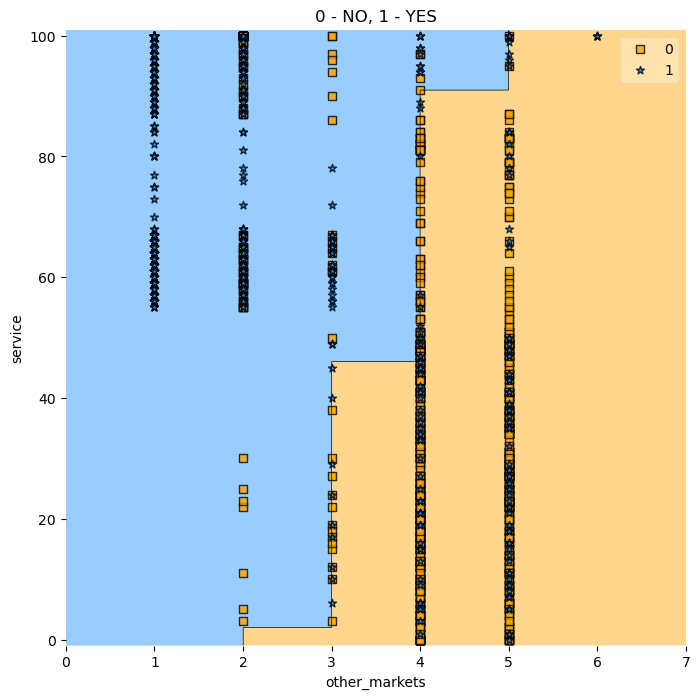

In [38]:
plt.figure(figsize=(8, 8))
figure2 = plot_decision_regions(X_test_clf2.to_numpy(),
                                y_test_clf.to_numpy(),
                                clf=lg_clf2,
                                colors='orange,dodgerblue',
                                markers='s*')
plt.xlabel('other_markets')
plt.ylabel('service')
plt.title('0 - NO, 1 - YES', size=12)

### Analysis of classification methods

#### Random Forest

In [39]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [40]:
my_search_rf = RandomizedSearchCV(rf_clf,
                                  param_distributions={
                                      'max_depth': range(1, 20),
                                      'n_estimators': range(50, 150, 10),
                                      'min_samples_leaf': [3, 5, 7, 9]
                                  },
                                  **search_params)
my_search_rf.fit(X_train_clf, y_train_clf)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': range(1, 20),
                                        'min_samples_leaf': [3, 5, 7, 9],
                                        'n_estimators': range(50, 150, 10)},
                   random_state=42, scoring='accuracy')

Hyperparameter tuning was used for each model. Due to the rather large number of combinations (in the above case $20*10*4=400$ observations), the *RandomizedSearchCV()* method selecting parameter values randomly was used. For tuning the hyperparameters, the training set in each of **20 iterations** was divided five times. The aim is to maximise the **accuracy** parameter, i.e. correctly classified observations.

In [41]:
print(my_search_rf.best_params_)
print(my_search_rf.best_score_)

{'n_estimators': 60, 'min_samples_leaf': 3, 'max_depth': 8}
0.8368200836820083


The best result was an average of five subsets equal to approximately **83.68%** of correctly classified observations.

In [42]:
rf_optimal = my_search_rf.best_estimator_

In [43]:
y_pred_rf_clf = rf_optimal.predict(X_test_clf)

In [44]:
rf_optimal.score(X_test_clf, y_test_clf)

0.8467202141900937

When the model was tested on the test set, the result was about one percentage point better, which speaks rather well of the model.

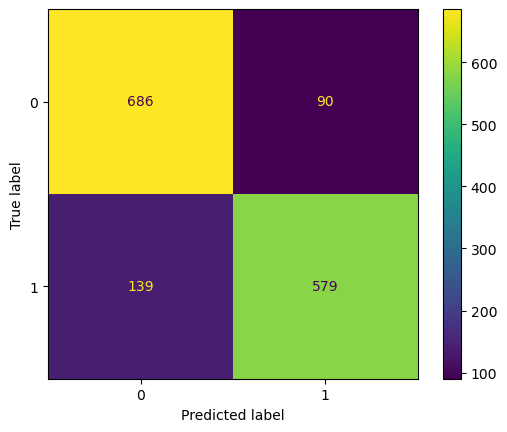

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_rf_clf)
plt.show()

In [46]:
print(classification_report(y_test_clf, y_pred_rf_clf))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       776
           1       0.87      0.81      0.83       718

    accuracy                           0.85      1494
   macro avg       0.85      0.85      0.85      1494
weighted avg       0.85      0.85      0.85      1494



The confusion matrix shows that for both ‘classes’ the algorithm exhibits a similar level of performance. There are significantly more observations on the main diagonal, which is the desired result. The *classification_report()* method shows results that are easier to interpret:


- For the ‘NO’ group:
    - 83% of the customers who were classified as not visiting the market again actually did not visit the market again (*precision*)
    - 88% of the customers who did not visit the market again were correctly classified (*recall*)
- For the ‘YES’ group:
    - 87% of the customers who were categorised as re-visiting the market actually re-visited the market (*precision*)
    - 81% of re-visiting customers were correctly categorised (*recall*)

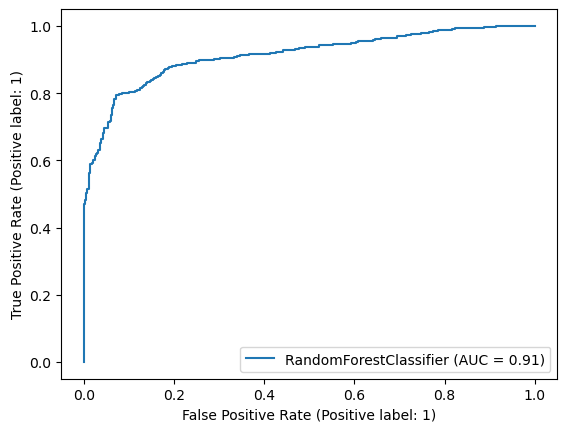

In [47]:
RocCurveDisplay.from_estimator(rf_optimal, X_test_clf, y_test_clf)
plt.show()

The ROC graph shows that theoretically there is room for improvement, however, the area under the ROC curve equals 0.91 which is still quite satisfactory.

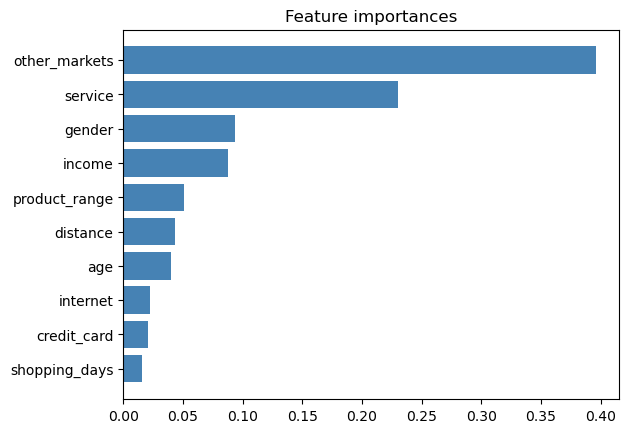

In [48]:
feature_importance_plot(rf_optimal.feature_importances_, X_clf)

From the feature importance chart, it can be clearly seen that the most dominant features are:
- ‘other’ - i.e. the number of other markets where the customer shops
- ‘service’ - satisfaction with service at market X

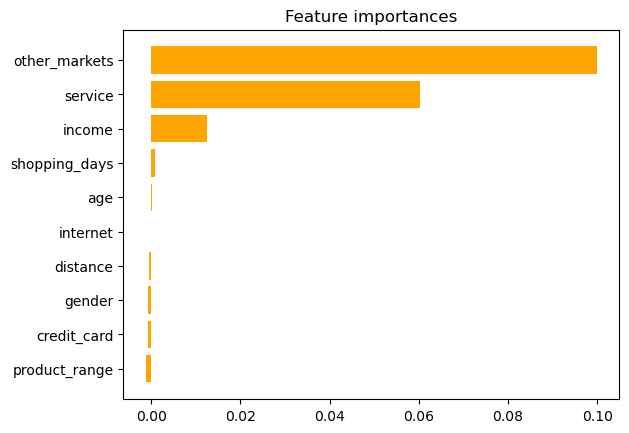

In [49]:
permutated_importances_rf_clf = permutation_importance(rf_optimal,
                                                       X_test_clf,
                                                       y_test_clf,
                                                       random_state=42)

feature_importance_plot(permutated_importances_rf_clf.importances_mean,
                        X_clf,
                        permutated=True)

After applying the permutated importance technique, the same two characteristics continue to dominate, while the negligible significance of all characteristics except the two previously mentioned and income is highlighted.

#### Gradient Boosting

In [50]:
gboost_clf = GradientBoostingClassifier(random_state=42)

In [51]:
my_search_gboost = RandomizedSearchCV(
    gboost_clf,
    param_distributions={
        'max_depth': range(1, 20),
        'n_estimators': range(50, 150, 10),
        'min_samples_leaf': [3, 5, 7, 9],
        'learning_rate': [0.05, 0.1, 0.3, 0.5, 1, 3, 5, 7, 10]
    },
    **search_params)
my_search_gboost.fit(X_train_clf, y_train_clf)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.3, 0.5,
                                                          1, 3, 5, 7, 10],
                                        'max_depth': range(1, 20),
                                        'min_samples_leaf': [3, 5, 7, 9],
                                        'n_estimators': range(50, 150, 10)},
                   random_state=42, scoring='accuracy')

The last algorithm considered is the *GradientBoostingClassifier*, which is also based on decision trees. It has, among the selected algorithms, a relatively large number of possible hyperparameters for tuning, but was limited to ‘only’ four, which was considered sufficient to strike a balance between underlearning and overlearning.

In [52]:
print(my_search_gboost.best_params_)
print(my_search_gboost.best_score_)

{'n_estimators': 50, 'min_samples_leaf': 7, 'max_depth': 3, 'learning_rate': 0.1}
0.837489539748954


The average score from 5 splits for the best drawn hyperparameter combination is very close to that of the random forest. However, it should also be taken into account that the tuning of the hyperparameters for this classifier took much longer than for the ‘predecessor’.

In [53]:
gboost_optimal = my_search_gboost.best_estimator_

In [54]:
y_pred_gboost_clf = gboost_optimal.predict(X_test_clf)

In [55]:
gboost_optimal.score(X_test_clf, y_test_clf)

0.8507362784471219

The score of 85% on the test set is also the better one.

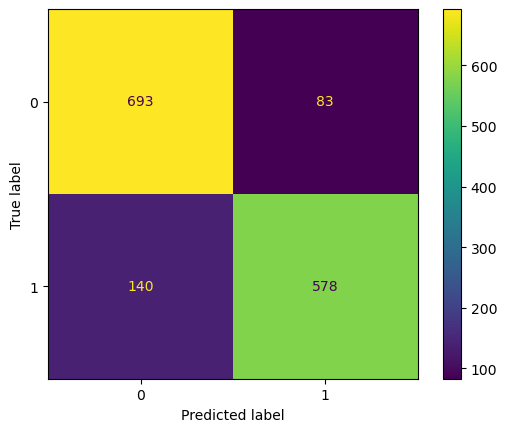

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_gboost_clf)
plt.show()

In [57]:
print(classification_report(y_test_clf, y_pred_gboost_clf))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       776
           1       0.87      0.81      0.84       718

    accuracy                           0.85      1494
   macro avg       0.85      0.85      0.85      1494
weighted avg       0.85      0.85      0.85      1494



The results from the confusion matrix are comparable to those from the random forest. Only the *recall* for the ‘NO’ group is 1 p.p. higher.

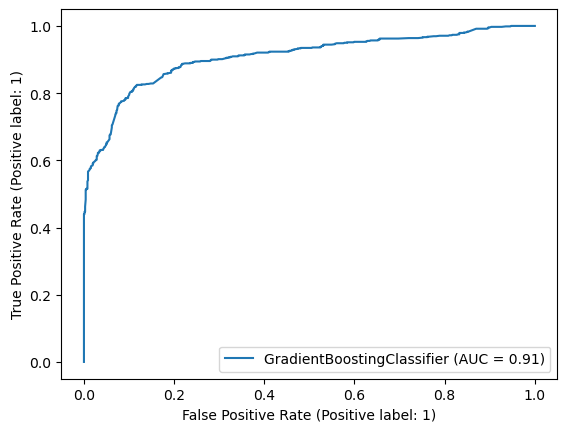

In [58]:
RocCurveDisplay.from_estimator(gboost_optimal, X_test_clf, y_test_clf)
plt.show()

The AUC result is the same as for the random forest.

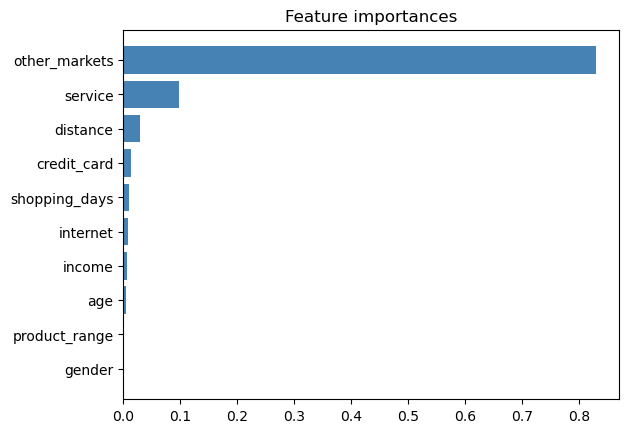

In [59]:
feature_importance_plot(gboost_optimal.feature_importances_, X_clf)

It seems that the *GradientBoosting* algorithm is much more restrictive when it comes to the importance of features - the first two, namely *other_markets* and *service*, can be simplistically assumed to be the only relevant ones.

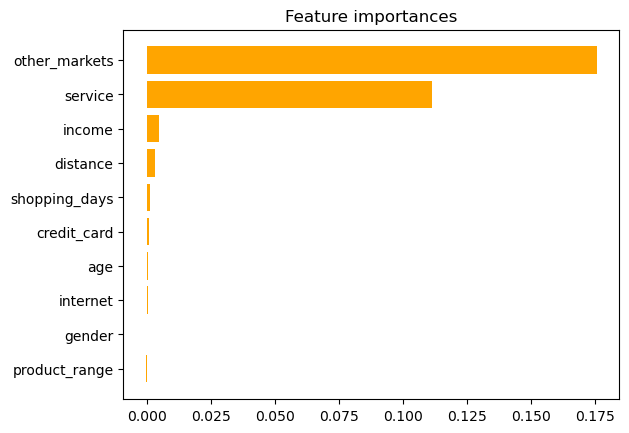

In [60]:
permutated_importances_gboost_clf = permutation_importance(gboost_optimal,
                                                           X_test_clf,
                                                           y_test_clf,
                                                           random_state=42)

feature_importance_plot(permutated_importances_gboost_clf.importances_mean,
                        X_clf,
                        permutated=True)

In the case of the permutation technique, similar results were obtained, at most the significance of the *service* trait was found to be significantly higher. 

In [61]:
X_clf.head()

,product_range,service,shopping_days,income,other_markets,internet,credit_card,age,gender,distance
0,54,64,2,2.1,3,0,0,54,0,1.6
1,86,88,6,2.3,2,0,1,72,1,6.5
2,56,60,2,2.1,3,0,0,56,1,0.4
3,54,61,2,2.1,3,0,1,60,1,6.5
4,63,60,2,2.1,3,0,0,41,1,7.3


### Summary of classification methods

Both algorithms used performed very well on both the training and test sets - the results showed no overfitting of the models. The results of measures such as *precision* and *recall* on both groups of customers were very close to each other, so the question of whether to pay more attention to customers who stay or those who do not stay makes no difference when comparing the algorithms. However, the best choice seems to be *GradientBoostingClassifier*, which had marginally higher accuracy and well-optimised feature selection, although it takes much more time to train.

**Interpretation of results (SHAP package)**

To better understand the performance of the chosen classifier, the *SHAP* package was used. <br>

SHAP is a method based on game theory used for enhancing transparency and interpretability of machine learning models.

In [62]:
explainer = shap.Explainer(gboost_optimal.predict, X_test_clf)

shap_values = explainer(X_test_clf)

Exact explainer: 1495it [03:03,  7.84it/s]                                                                             


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


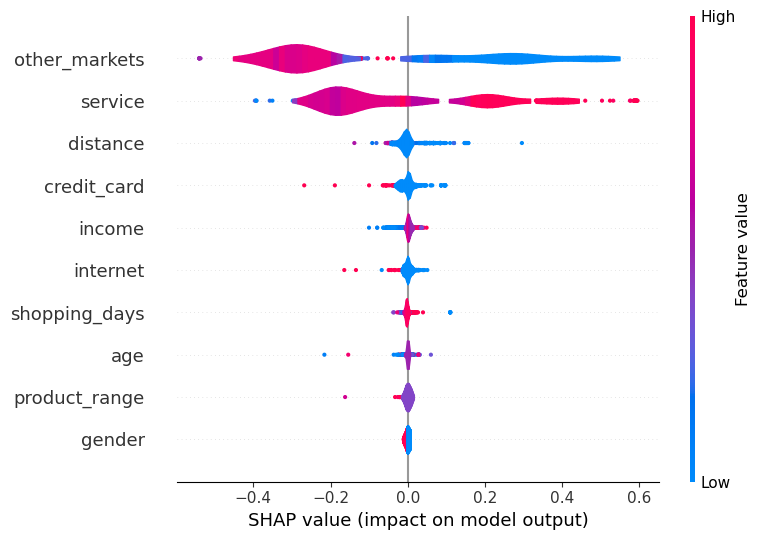

In [63]:
shap.summary_plot(shap_values, plot_type='violin')

The graph shows both the relevance of the features and the density and relevance of their values. For example, the high number of other markets visited (right) contributes significantly to the underestimation of values (blue colour).

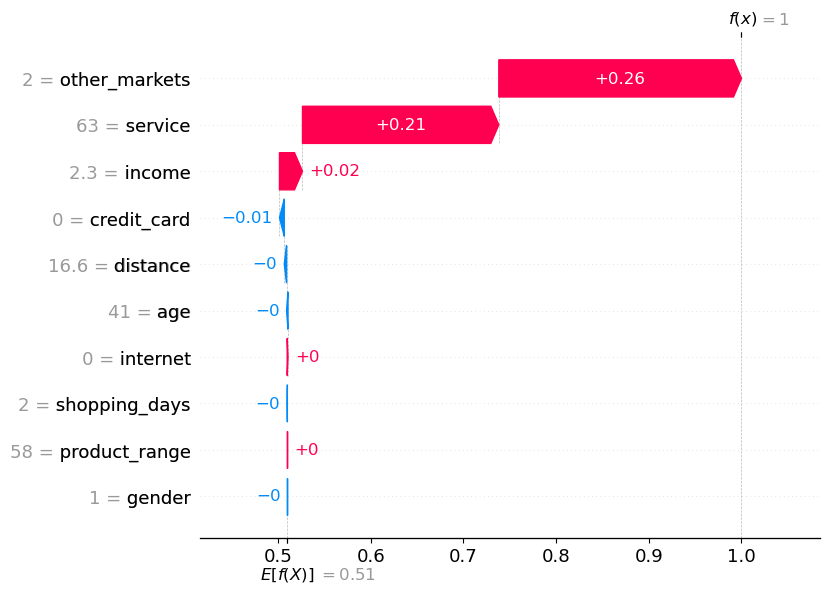

In [64]:
shap.plots.waterfall(shap_values[4])

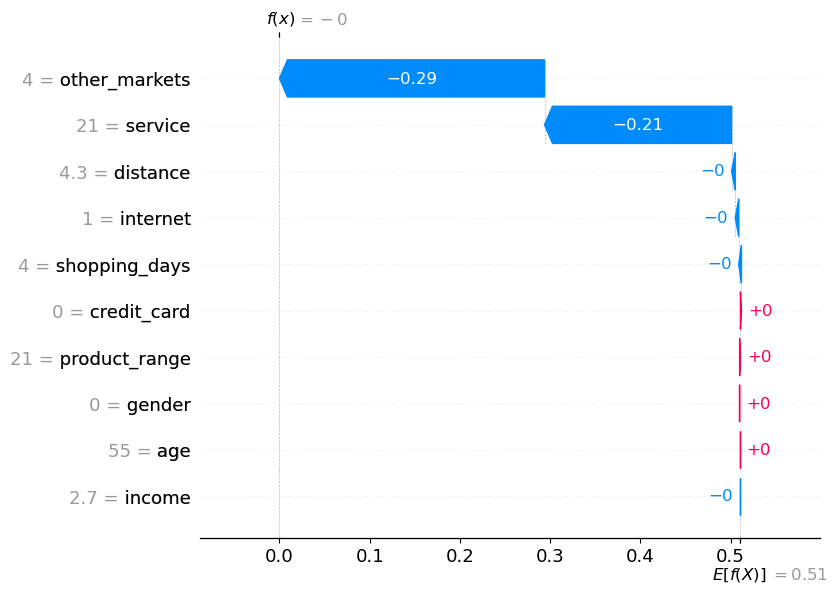

In [65]:
shap.plots.waterfall(shap_values[42])

It was also decided to check how the characteristics contribute to the final prediction value for the two extreme (mainly in terms of the two most important characteristics) observations. In the case of observation *#4*, where the customer only shops at two other markets and rates the service at *63/100*, the values significantly steer the result towards a group of customers who return willingly to the market. In contrast, in the case of observation *nr 42*, where the customer shops in four other markets and rates the service of market X low (*21/100*), the algorithm is inclined to assign the customer to the group of non-returners.

## Conclusion

- The features that determine whether a customer will shop at Market X again depend mainly on how many other markets they have shopped at and their individual rating of service
- To increase the chances of customer retention it is likely necessary to increase the competitiveness of the market, including by improving e.g. the quality of service.
- Other ways could be loyalty programmes, a wider range of products available, strategic product pricing, market segmentation or increasing staff morale - satisfied staff are more likely to provide better customer service, which has a positive impact on customer retention.

In general, only helpful suggestions are listed above. To better investigate what affects the competitiveness of the markets, other data should be collected that could show important influences.